# Classify spoken numbers 0-9 with PylotWhale

* In this notebook we use [pylotWhale](https://github.com/floreencia/pylotwhale) to classify audio signals of spoken digits (0-9)
* We use the [AudioMNIST dataset](https://github.com/soerenab/AudioMNIST)
* In a previous notebook (01_createAnnsDataframe.ipynb) we created a dataframe with the paths to the audio files and their labels
* Training the model takes ca. 10 minutes in my 2019 MacBook. To reduce this time you can decrease the size of the training.   

## Settings

### Import modules

In [31]:
import sys
import os
from importlib import reload

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa as lb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split #cross_val_score
import sklearn.metrics as mt

import pylotwhale.utils.plotTools as pT
import pylotwhale.MLwhales.MLtools_beta as myML
import pylotwhale.MLwhales.featureExtraction as fex
import pylotwhale.MLwhales.MLEvalTools as evT
from pylotwhale.MLwhales.clf_pool import svc_l, svc_rbf, random_forest # as clf_settings

In [32]:
import constants
reload(constants)
from constants import *

### Set paths

In [8]:
collectionF = LABELLED_COLL
oFigDir = SPECTROS_DIR

### Load collection dataframe

In [12]:
colldf = pd.read_csv(collectionF, dtype={'label': 'str'})

# Inspect dataset
print("Dataset size", len(colldf))
print(colldf['label'].value_counts())
print(colldf.info())
colldf.head()

Dataset size 30000
7    3000
2    3000
3    3000
9    3000
4    3000
1    3000
8    3000
5    3000
6    3000
0    3000
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    30000 non-null  object
 1   label   30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB
None


,file,label
0,/Users/florencia/Science/datasets/audio/AudioM...,7
1,/Users/florencia/Science/datasets/audio/AudioM...,7
2,/Users/florencia/Science/datasets/audio/AudioM...,2
3,/Users/florencia/Science/datasets/audio/AudioM...,3
4,/Users/florencia/Science/datasets/audio/AudioM...,9


## Visualise data


In [13]:
def visualiseSample(i, df, oFigDir):
    """
    Parameters
    ----------
    i: int
        index of the sample
    df: DataFrame
        dataframe with annotations t0, tf, wavF, annF, l   
    oFigDir: string
        directory where to save the spectrograms
    """
    thisRec = df.iloc[i].to_dict()
    #print(thisRec['label'])
    ## load audio file
    yi, sr = lb.core.load(thisRec['file'], sr=None)
    
    ## plot spectrum
    fig, ax = plt.subplots(figsize=(2,4))

    fig, ax = pT.plspectro(yi, sr, spec_fac=1, ax=ax, 
                       xl='time (s)', yl='frequency (kHz)', cmN='viridis', fig=fig)

    ax.text(0.1, 20, '{}'.format(thisRec['label']), style='italic', fontsize=20,
            bbox={'facecolor':'white', 'alpha':0.75, 'pad':5})

    oFig = os.path.join(oFigDir, '{}_{}s.png'.format( os.path.splitext(os.path.basename(thisRec['file']))[0], i))
    #print(oFig)
    fig.savefig(oFig, bbox_inches='tight')
    return oFig

### Visualise 10 random samples

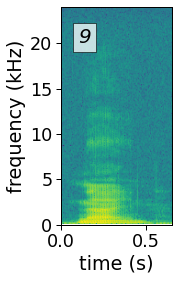

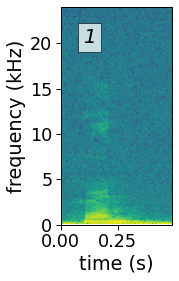

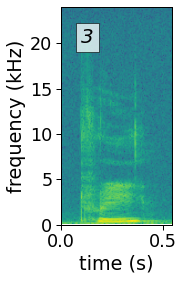

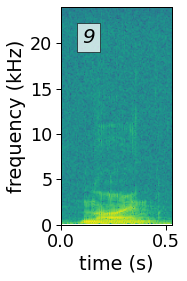

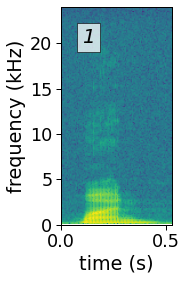

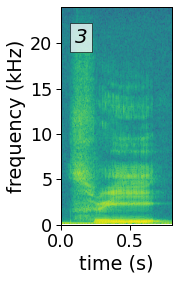

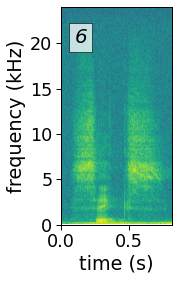

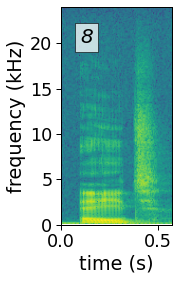

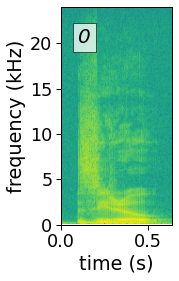

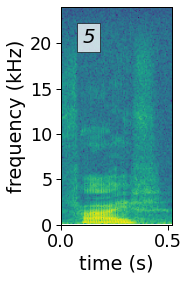

In [14]:
n = 10
for i in np.random.randint(0, len(colldf), n):
    visualiseSample(i, colldf, oFigDir)

Determine sampling rate and NFFT

In [15]:
i=3
thisRec = colldf.iloc[i].to_dict()
yi, sr = lb.core.load(thisRec['file'], sr=None)
fft_ws = 512
print("Sampling rate {}, NFFT {}".format(sr, fft_ws))

Sampling rate 48000, NFFT 512


## Feature extraction 

### Create feature extraction pipeline

In [16]:
#### initialise transformation settings
T_settings = []

#### preprocessing
## band pass filter
filt = 'band_pass_filter'
filtDi = {"fs": sr, "lowcut": 1500, "highcut": 2400, "order": 5}
#T_settings.append(('bandFilter', (filt, filtDi)))

## normalisation
prepro = 'maxabs_scale'
preproDict = {}
T_settings.append(('normaliseWF', (prepro, preproDict)))

#### audio features
auD = {}
auD["fs"] = sr
auD["NFFT"] = fft_ws
auD["overlap"] = 0 #overlap
auD["n_mels"] = 8
#auD["fmin"] = 1200
audioF = 'melspectro' #'MFCC'
T_settings.append(('Audio_features', (audioF, auD)))

#### summarisation features
summDict = {'Nslices': 5, 'normalise': True}
summType = 'splitting'
T_settings.append(('summ', (summType, summDict)))

Tpipe = fex.makeTransformationsPipeline(T_settings)
print(T_settings)
print(Tpipe.string)

feExFun = Tpipe.fun

[('normaliseWF', ('maxabs_scale', {})), ('Audio_features', ('melspectro', {'fs': 48000, 'NFFT': 512, 'overlap': 0, 'n_mels': 8})), ('summ', ('splitting', {'Nslices': 5, 'normalise': True}))]
-normaliseWF-maxabs_scale-Audio_features-melspectro-fs_48000-NFFT_512-overlap_0-n_mels_8-summ-splitting-Nslices_5-normalise_True


Labels

In [17]:
classes = colldf['label'].unique()
lt = myML.labelTransformer(classes)
print("Classes we train on: {}, \nencoded by {}".format(lt.classes_, 
                                                      lt.nom2num(lt.classes_)))

Classes we train on: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9'], 
encoded by [0 1 2 3 4 5 6 7 8 9]


### Feature representation of one sample

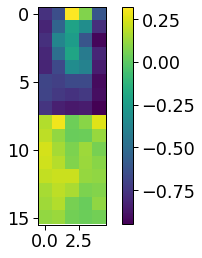

In [18]:
plt.imshow(feExFun(yi).T)
plt.colorbar()

### Extract features of the whole collection

This step can take quite some time (ca. 5 minutes in my 2019 MacBook). You can save time by reducing the size of the collection. 

In [19]:
wavsLabs_coll = colldf[['file', 'label']].values
datO = fex.wavLCollection2datXy(wavLabelCollection=wavsLabs_coll, fs=sr, 
                                featExtFun=feExFun)

In [20]:
np.shape(datO.X)

(30000, 80)

### Read data into features matrix X and labels vector y

In [22]:
# load data into matrix
X = datO.X
# load labels in to features matrix
y_names = datO.y_names
# convert labels into numerical labels
y = lt.nom2num(y_names)

print("Class counts", datO.targetFrequencies())

Class counts {'7': 3000, '2': 3000, '3': 3000, '9': 3000, '4': 3000, '1': 3000, '8': 3000, '5': 3000, '6': 3000, '0': 3000}


### Visualise features

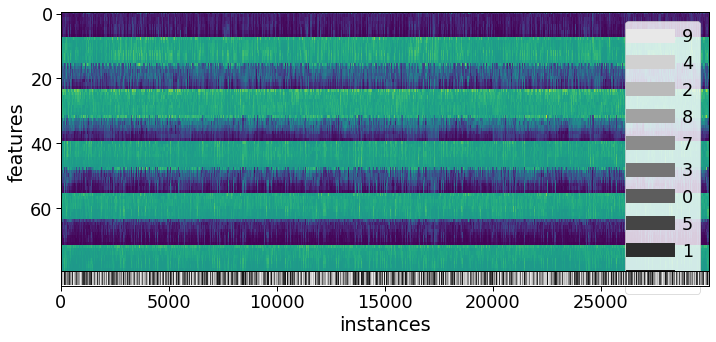

In [23]:
myML.plXy(X.T, y_names, figsize=(10,4), cmapName_Fig='viridis')

oFig = os.path.join(oFigDir, Tpipe.string + '.png')

oFig = os.path.join(oFigDir, 'feature_matrix-{}.png'.format('_'.join(classes)))
#plt.savefig(oFig, bbox_inches='tight')

## Train model

### Split data into train and test sets and shuffle samples

Counter({8: 327, 6: 321, 5: 311, 7: 303, 3: 303, 9: 301, 2: 300, 1: 290, 0: 282, 4: 262}) Counter({4: 2738, 0: 2718, 1: 2710, 2: 2700, 9: 2699, 3: 2697, 7: 2697, 5: 2689, 6: 2679, 8: 2673})


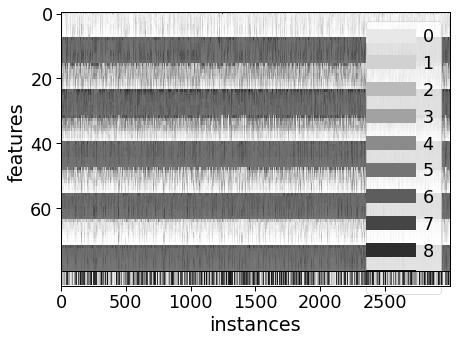

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.9,
                                                    random_state=0)

myML.plXy(X_train.T, y_train) # visualise train set
print(Counter(y_train), Counter(y_test))

### Carry out a grid search to tune classifier hyperparameters

Classifier settings

In [25]:
lt.nom2num(lt.classes_)
lt.classes_
lt.nom2num('0')


0

In [26]:
clf_settings = svc_rbf #random_forest #svc_rbf# # svc_l #
cv = 10  # cross validation folds for hyperparameter tuning via grid search
scoring = mt.make_scorer(mt.f1_score, labels=lt.nom2num(lt.classes_), average='macro') #'accuracy'

## define clf pipeline
clf_pipe = []
clf_pipe.append((clf_settings.pipeStep_name,  clf_settings.fun))
pipe = Pipeline(clf_pipe)
print("Clf pipeline:", clf_pipe)

## grid search parameters
paramsDi = {}
paramsDi.update(clf_settings.grid_params_di)
gs_grid = [paramsDi]
print("\nGrid search parameters:", paramsDi)
gs = GridSearchCV(estimator=pipe,
                  param_grid=gs_grid,
                  scoring=scoring,
                  cv=cv,
                  n_jobs=-1)

Clf pipeline: [('clf', SVC())]

Grid search parameters: {'clf__C': [0.1, 1.0, 10.0, 100], 'clf__gamma': [0.1, 1.0, 10.0]}


### Print all settings

In [27]:
print(Tpipe.string)
print(scoring, cv)
print("Clf pipeline:", clf_pipe)
print("Grid search parameters:", paramsDi)

-normaliseWF-maxabs_scale-Audio_features-melspectro-fs_48000-NFFT_512-overlap_0-n_mels_8-summ-splitting-Nslices_5-normalise_True
make_scorer(f1_score, labels=[0 1 2 3 4 5 6 7 8 9], average=macro) 10
Clf pipeline: [('clf', SVC())]
Grid search parameters: {'clf__C': [0.1, 1.0, 10.0, 100], 'clf__gamma': [0.1, 1.0, 10.0]}


### Fit model

This step can take a while 

In [28]:
gs = gs.fit(X_train, y_train)

# print scores
clf_svc_best = gs.best_estimator_
print(scoring, clf_svc_best )
print(gs.best_score_)

make_scorer(f1_score, labels=[0 1 2 3 4 5 6 7 8 9], average=macro) Pipeline(steps=[('clf', SVC(C=10.0, gamma=1.0))])
0.9883140045273049


print score

## Evaluate model on test set

### Print P, R and f1 scores for test collection

Scores by class and scoring summary

## Evaluate over the test set

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2718
           1       0.99      0.98      0.98      2710
           2       0.98      0.99      0.99      2700
           3       0.99      0.99      0.99      2697
           4       0.99      0.99      0.99      2738
           5       0.98      0.98      0.98      2689
           6       1.00      0.99      0.99      2679
           7       0.99      0.99      0.99      2697
           8       0.99      0.99      0.99      2673
           9       0.98      0.98      0.98      2699

    accuracy                           0.99     27000
   macro avg       0.99      0.99      0.99     27000
weighted avg       0.99      0.99      0.99     27000



(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

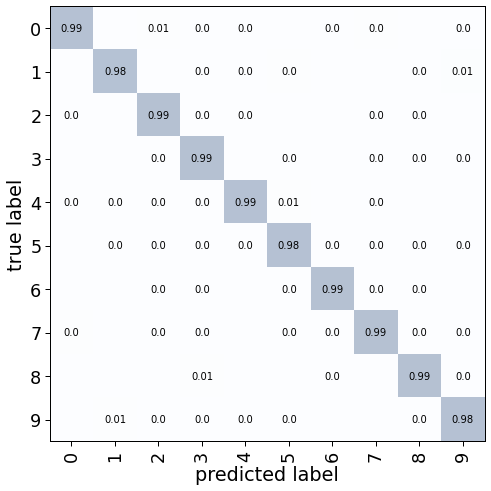

In [30]:
y_true, y_pred = y_test, clf_svc_best.predict(X_test)
print(mt.classification_report(y_true, y_pred, target_names=lt.num2nom(list(set(y)))))

## confusion matrix
cm = mt.confusion_matrix(y_true, y_pred)  # counts
cm_n = myML.scale(cm, normfun=myML.colCounts2colFreqs) # normalised for each class

fig, ax = evT.plConfusionMatrix(cM=cm_n, labels=lt.classes_, display_nums=False, figsize=(8, 8))# 
                                #outFig='/Users/florencia/Desktop/text.png',
                                #alpha=0.53, display_nums=False)

pT.display_numbers(fig, ax, cm_n, 10, 
                   fmt=lambda x: np.round(x, decimals=2), # display numbers with a 2 digit precision
                   condition=lambda x: x>0) # omit zeros

#ofig = os.path.join(oDir, 'CM-normalised.png')
#fig.savefig(ofig,  bbox_inches='tight')